# A Gentle Introduction to Time Series Analyis

This notebook provides an End-to-End Time Series pipeline. 

The pipeline covers basic time series analysis concepts:
- **Time Series Visualization** - Lineplot / Scatterplot
- **Time Series Components**
    - Trend, Seasonality & Noise
    - Stationarity
    - Self-correlation
- **Data Wrangling**
    - Resampling
    - Noise Reduction
- **Time Series Forecasting** - AR + MA + ARIMA
- **Feature Generation using Time Series** - Generate features for your Machine Learning model


All background concepts were covered at the [Analytics Vidhya DataHour lecture](https://docs.google.com/presentation/d/1T2RNXirziEr35_OGOYK_JCmmVOEau5hk3XMG5GxZYMo/edit?usp=sharing) by Miguel Cacho Soblechero, PhD

# 0. Requirements

### Download and import packages

In [85]:
# Install and Import Necessary Libraries
!pip install statsmodels
!pip install pandas
!pip install tqdm
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [94]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from tqdm import tqdm
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

### Download dataset

In [3]:
# Load the AirPassengers Dataset
# AirPassengers = sm.datasets.get_rdataset("AirPassengers").data
air_passengers = pd.read_csv("AirPassengers.csv").rename(
    {"Month": "date", "#Passengers": "num_passengers"}, axis=1
)
air_passengers["date"] = pd.to_datetime(air_passengers["date"])
air_passengers.head()

,date,num_passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


# 1. Time Series Visualization

The evolution of the values with time is usually visualized using either a **lineplot** or a **scatterplot**. 

The **lineplot** creates a "cleaner" view of the evolution of values with time. This is done by connecting every point with the adjacent with a line. However, if your data has missing intervals, it might create misleading visual artifacts.

The **scatterplot** avoids this problem by plotting the raw values with their corresponding timestamp, without establishing relationships between points. However, this makes it harder to interpreted.

In [54]:
# Plotting functions
def plot_lineplot_time_series(data: pd.DataFrame, x: str, y: str):
    # Basic plotting
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)


def plot_scatter_time_series(data: pd.DataFrame, x: str, y: str):
    # Basic plotting
    plt.figure(figsize=(15, 5))
    sns.scatterplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)


def plot_lineplot_two_timeseries(
    data_original: pd.DataFrame,
    x_original: str,
    y_original: str,
    data_processed: pd.DataFrame,
    x_processed: str,
    y_processed: str,
):
    # Basic plotting
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=data_original, x=x_original, y=y_original, label="Original")
    sns.lineplot(data=data_processed, x=x_processed, y=y_processed, label="Processed")

    # Format tick labels
    plt.xticks(rotation=45)

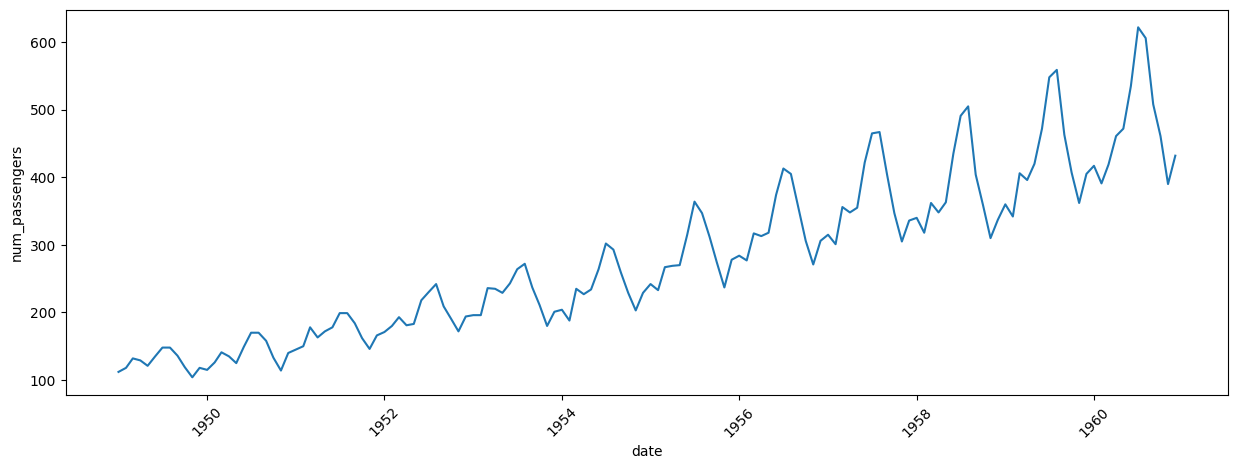

In [5]:
plot_lineplot_time_series(air_passengers, x="date", y="num_passengers")

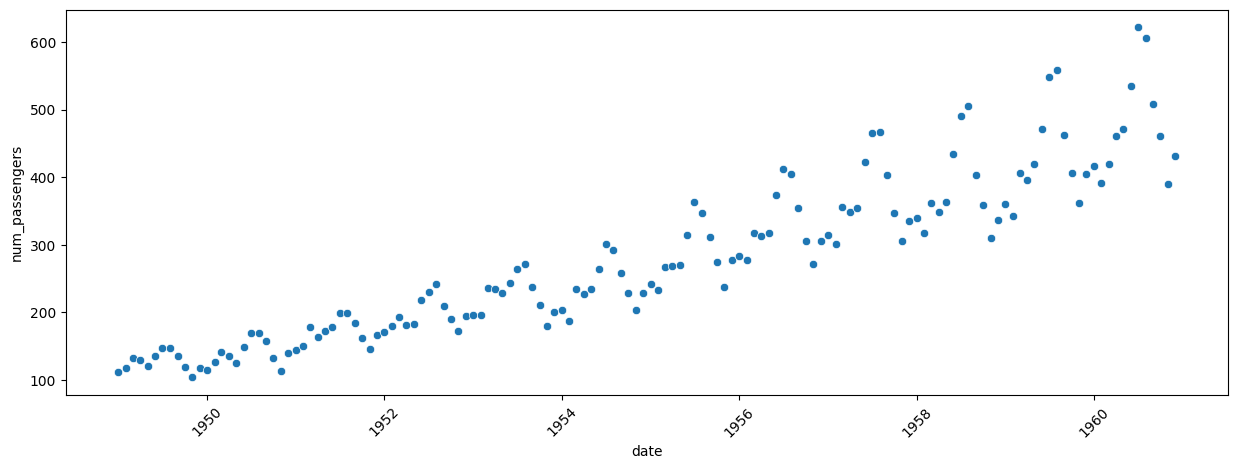

In [6]:
plot_scatter_time_series(air_passengers, x="date", y="num_passengers")

### What happens when we have missing data?

As mentioned before, the lineplot can create misleading visual effects if missing data is present.

In [7]:
available_months = range(0, 7)
air_passengers_with_missing_data = air_passengers.loc[
    air_passengers.date.dt.month.isin(available_months)
]

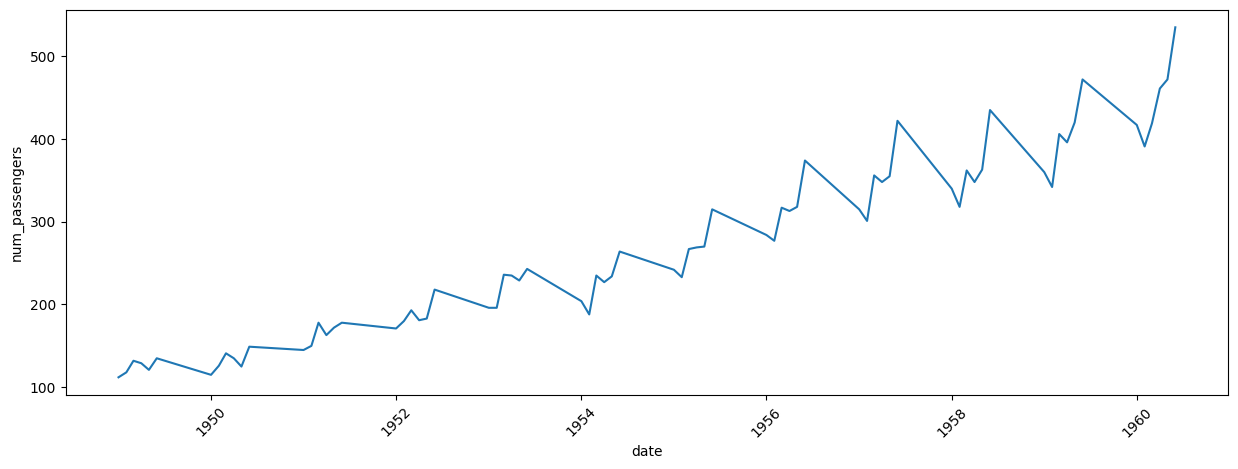

In [8]:
plot_lineplot_time_series(
    air_passengers_with_missing_data, x="date", y="num_passengers"
)

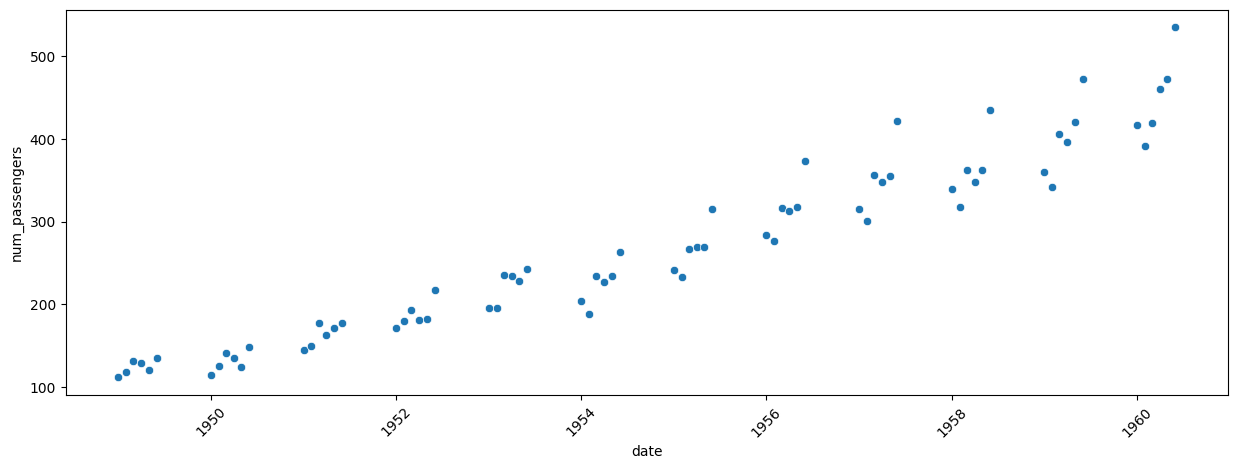

In [9]:
plot_scatter_time_series(air_passengers_with_missing_data, x="date", y="num_passengers")

# 2. Components of Time Series

## 2.1 Trend, Seasonality and Noise

Time Series can be decomposed in:
- Trend
- Seasonality
- Noise

To extract these components, we can leverage libraries such as statsmodels, which does the heavy lifting for us.

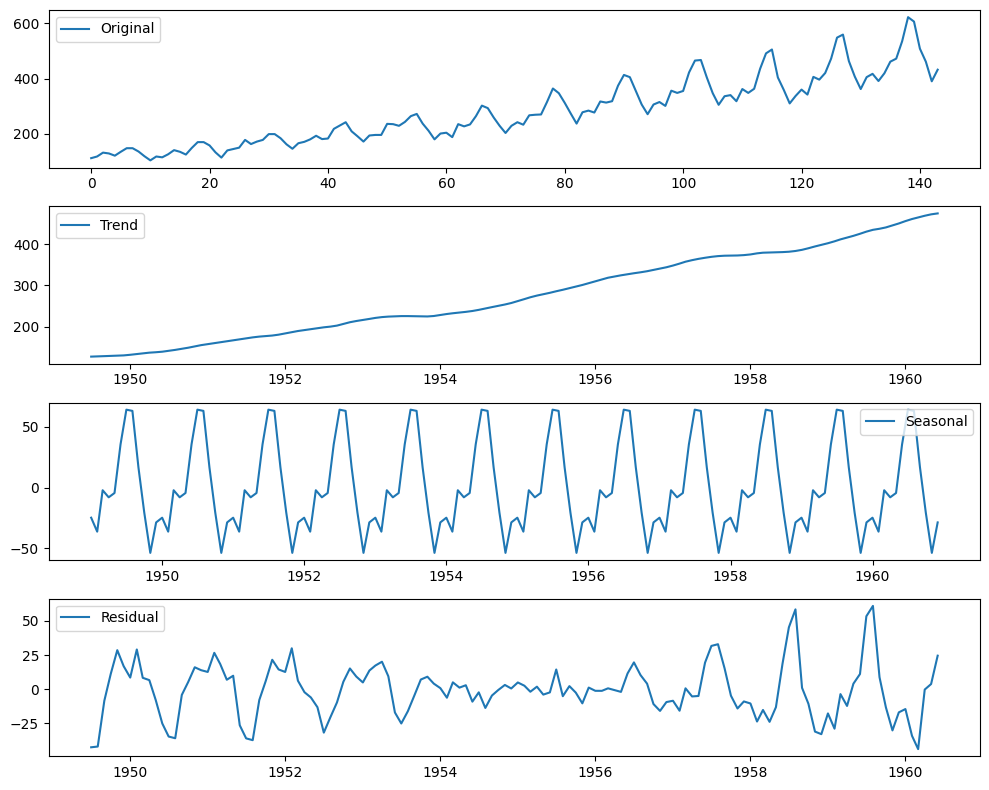

In [10]:
# Decompose the seasonal data
result = seasonal_decompose(
    air_passengers.set_index("date")["num_passengers"], model="additive"
)

# Plot the decomposed components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(air_passengers["num_passengers"], label="Original")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label="Trend")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label="Seasonal")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label="Residual")
plt.legend()

plt.tight_layout()
plt.show()

## 2.2. Stationarity

Stationarity measures if the time series statistical properties (like mean, variance, and autocorrelation) do not change over time.

In this section, we will test both the Augmented Dickey-Fuller (ADF) Test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test.
For it to be stationary:
- ADF p-value < 0.05
- KPSS p-value > 0.05 (trend-stationary)

In [11]:
# ADF Test
result_adf = adfuller(air_passengers["num_passengers"], autolag="AIC")
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"\t{key}: {value}")

# KPSS Test
result_kpss = kpss(air_passengers["num_passengers"], regression="c")
print("\nKPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f"\t{key}: {value}")

ADF Statistic: 0.8153688792060447
p-value: 0.9918802434376409
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598

KPSS Statistic: 1.6513122354165206
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


We can apply transformations to make the time series stationary, such as differentiation.

In [12]:
# ADF Test
result_adf = adfuller(air_passengers["num_passengers"].diff().dropna(), autolag="AIC")
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"\t{key}: {value}")

# KPSS Test
result_kpss = kpss(air_passengers["num_passengers"].diff().dropna(), regression="c")
print("\nKPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f"\t{key}: {value}")

ADF Statistic: -2.8292668241699794
p-value: 0.054213290283828236
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598

KPSS Statistic: 0.023897614400183967
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# 2.3. Self-Correlation

Self-correlation refers to the extend past values affect and define present values. Two plots can be generated to evaluate the self-correlation of a time series.
- Autocorrelation Function (ACF) - It plots the autocorrelation of a time series with its lags.
- Partial Autocorrelation Function (PACF) - It measures the correlation between a time series and its lagged values after removing the effects of intermediate lagged values.


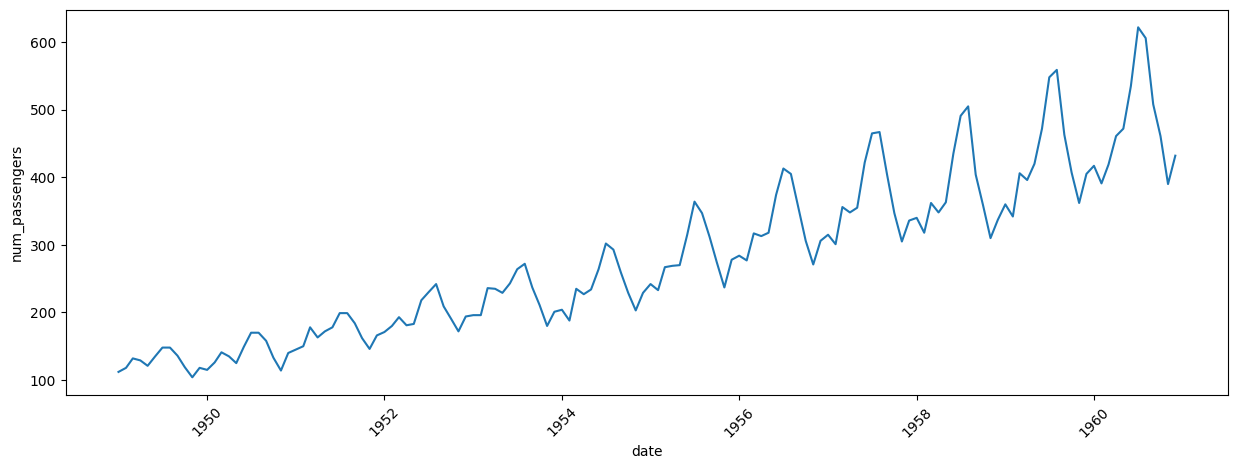

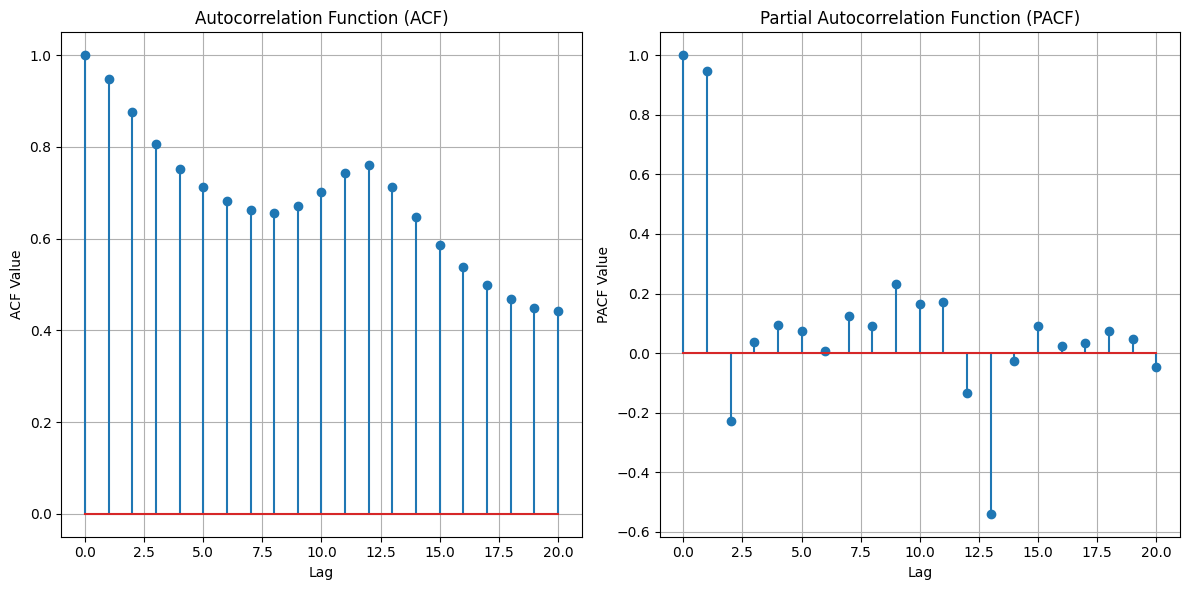

In [50]:
plot_lineplot_time_series(air_passengers, "date", "num_passengers")

# Compute the Autocorrelation Function (ACF)
acf = sm.tsa.acf(air_passengers.num_passengers.values, nlags=20, fft=False)

# Compute the Partial Autocorrelation Function (PACF)
pacf = sm.tsa.pacf(air_passengers.num_passengers.values, nlags=20, method=None)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plt.stem(acf)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF Value")
plt.grid(True)

# Plot PACF
plt.subplot(1, 2, 2)
plt.stem(pacf)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("PACF Value")
plt.grid(True)

plt.tight_layout()
plt.show()

From these ACF and PACF graphs, we can extract the following insights:
- Most points are correlated with each other, which indicates that numbers from the same season are likely to have similar values.
- The PACF shows a peak on month 13, where the trend is inversed. This indicates a yearly seasonality.

# 3. Data Wrangling in Time Series

# 3.1. Resampling

These methods modify the sampling frequency of the time series. 

## 3.1.1. Downsampling
Downsampling reduces the sampling frequency, using a variety of methods:
- Mean: Take the average of a period
- Sum: Accumulate values. This is not suitable for all measurements
- Median: Take the median of a period
- Max: Take the max of a period

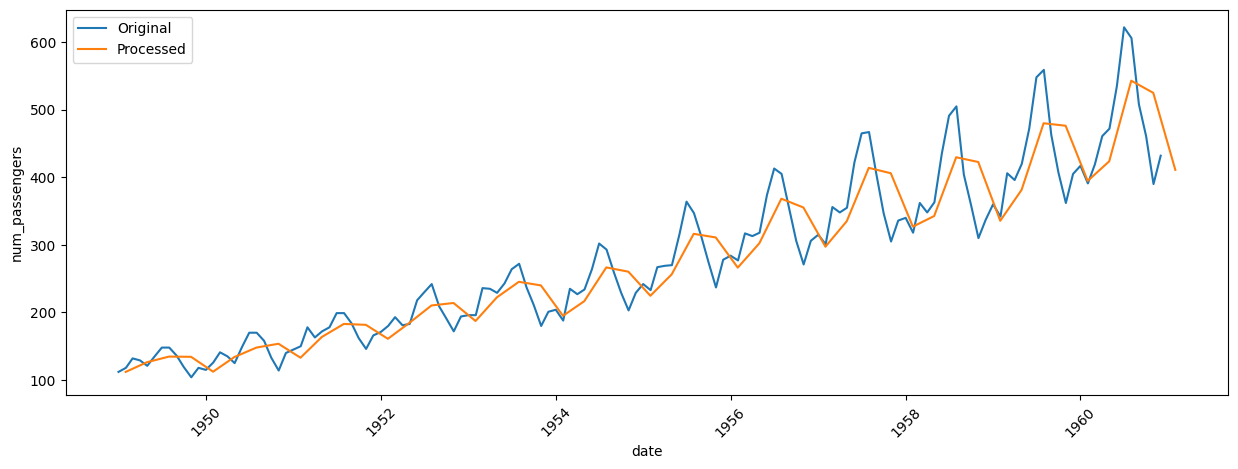

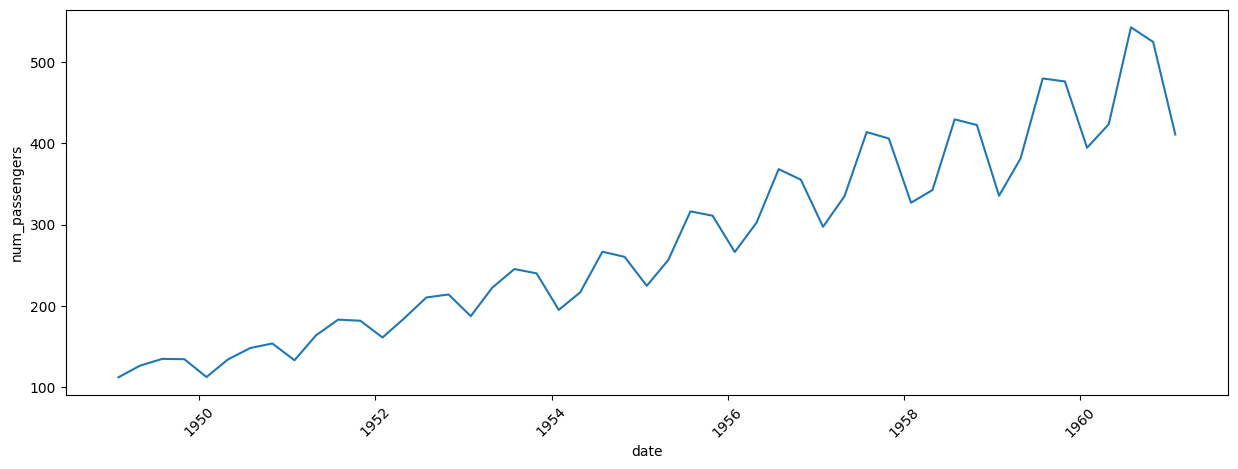

In [56]:
air_passengers_downsampled = (
    air_passengers.set_index("date").resample("3M").mean()
)  # '3M' stands for 3 months frequency, and mean() computes average
plot_lineplot_two_timeseries(
    data_original=air_passengers,
    x_original="date",
    y_original="num_passengers",
    data_processed=air_passengers_downsampled,
    x_processed="date",
    y_processed="num_passengers",
)
plot_lineplot_time_series(air_passengers_downsampled, "date", "num_passengers")

## 3.1.2. Upsampling
Upsampling creates new samples from the existing ones, using a variety of strategies:
- Imputation using forward-fill: Fill new samples with past values
- Interpolation: Fill new samples with the interpolated values between the two samples.

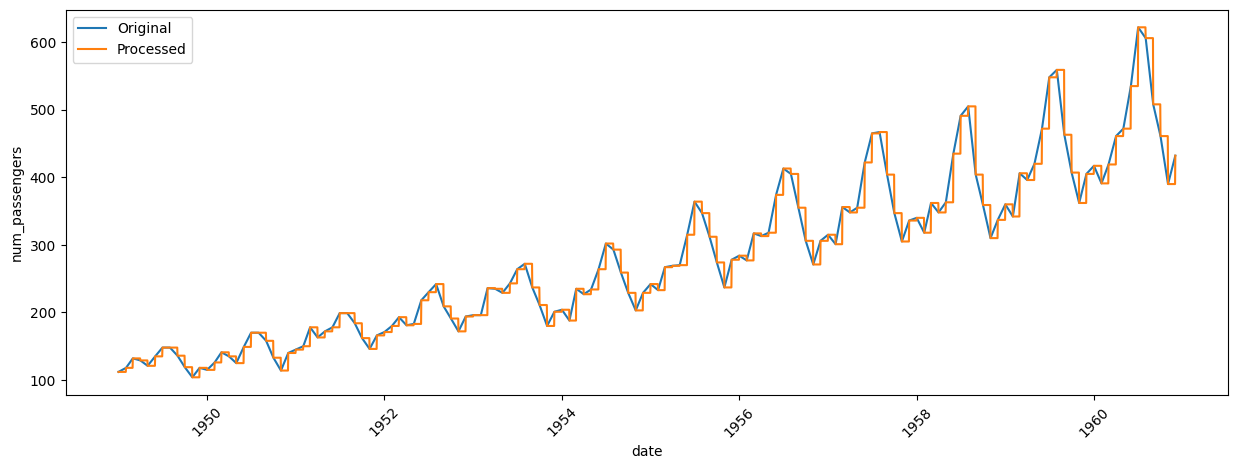

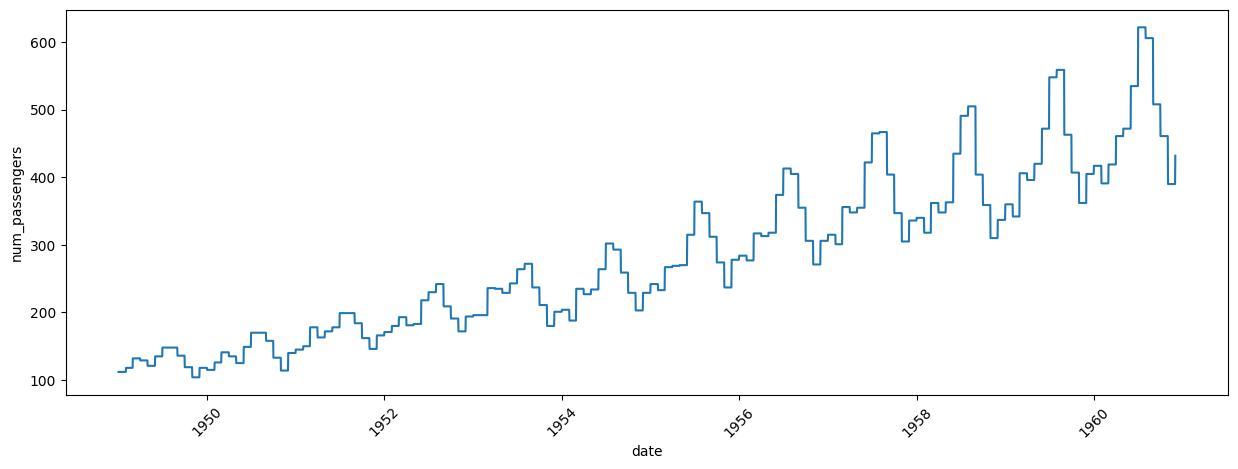

In [57]:
air_passengers_upsampled = (
    air_passengers.set_index("date").resample("D").ffill().reset_index()
)
plot_lineplot_two_timeseries(
    data_original=air_passengers,
    x_original="date",
    y_original="num_passengers",
    data_processed=air_passengers_upsampled,
    x_processed="date",
    y_processed="num_passengers",
)
plot_lineplot_time_series(air_passengers_upsampled, "date", "num_passengers")

# 3.2. Smoothing

This techniques eliminate the high frequency components (i.e. spikes and abnormal values) by averaging over a window.
I explore two main strategies:
- Moving average, using:
    - Trailing Moving Average - Using N past samples
    - Centered Moving Average - Centering the window on the sample, using N/2 samples forwards and backwards. CAREFUL: This can lead to lookahead.
    - Leading Moving Average - Using next N samples. CAREFUL: This can lead to lookahead.
- Exponential smoothing: Uses a weighted average approach. The most recent observation is given the most weight, and as you go back in time, the weights decrease exponentially.

### Moving Average

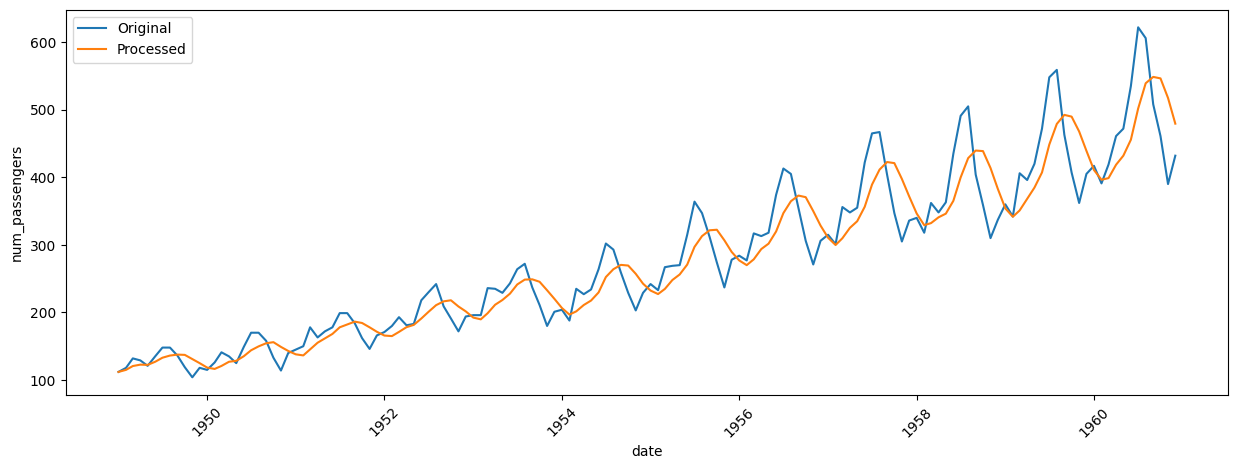

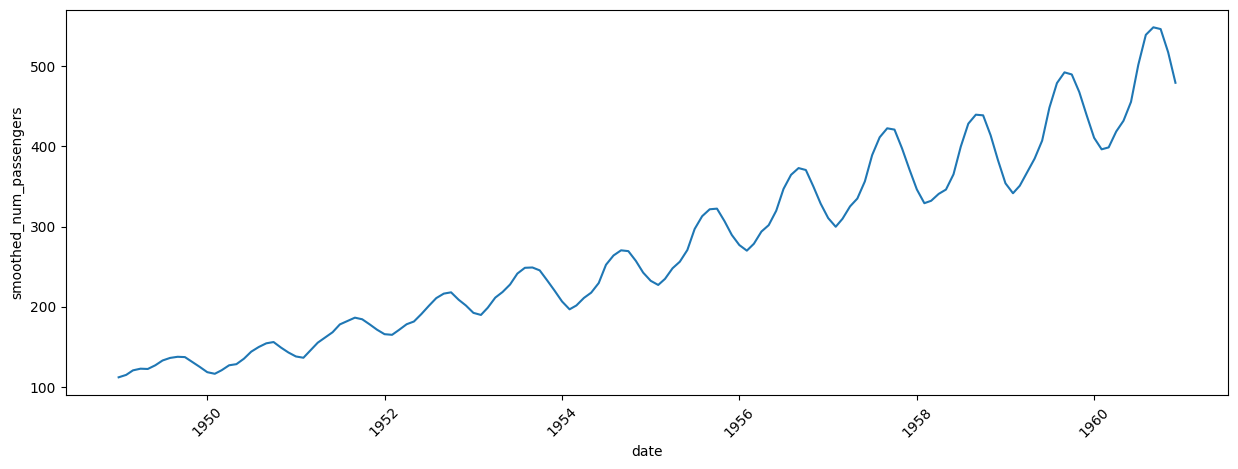

In [58]:
air_passengers["smoothed_num_passengers"] = (
    air_passengers["num_passengers"].rolling(window=5, min_periods=1).mean()
)
plot_lineplot_two_timeseries(
    data_original=air_passengers,
    x_original="date",
    y_original="num_passengers",
    data_processed=air_passengers,
    x_processed="date",
    y_processed="smoothed_num_passengers",
)
plot_lineplot_time_series(air_passengers, "date", "smoothed_num_passengers")

### Exponential Smoothing

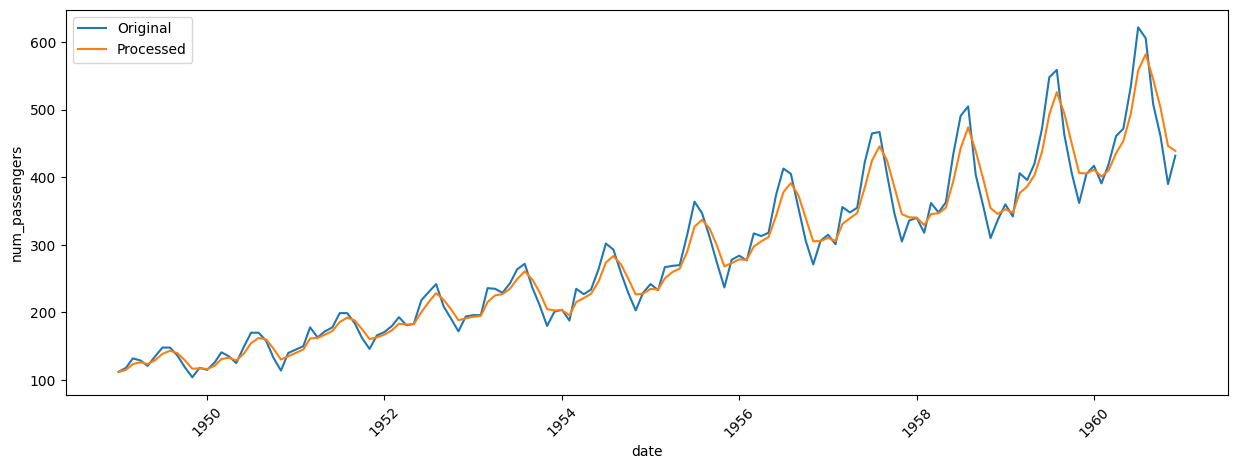

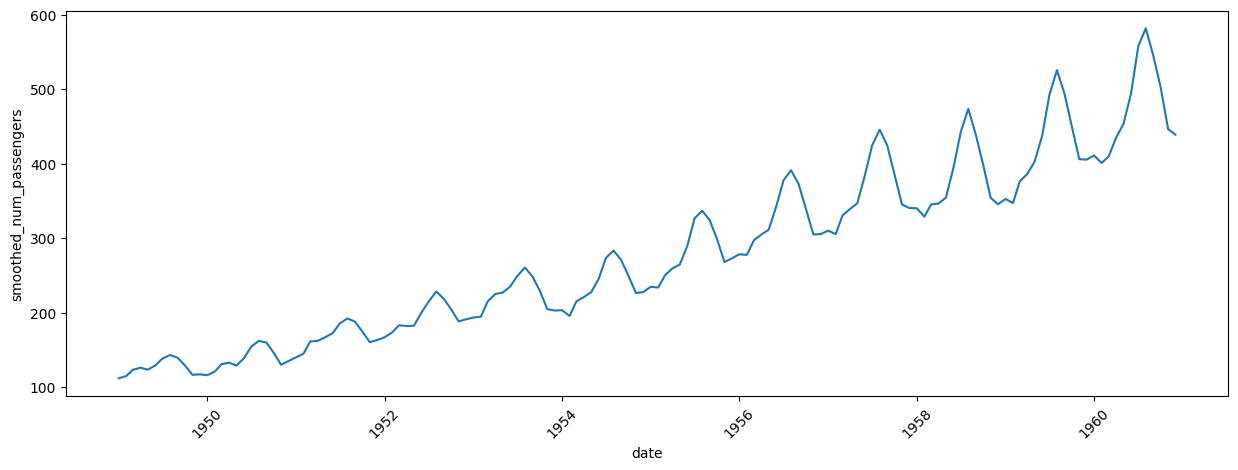

In [61]:
# Perform exponential smoothing
alpha = 0.5
air_passengers["smoothed_num_passengers"] = (
    air_passengers["num_passengers"]
    .ewm(alpha=alpha, adjust=False, ignore_na=True)
    .mean()
)
plot_lineplot_two_timeseries(
    data_original=air_passengers,
    x_original="date",
    y_original="num_passengers",
    data_processed=air_passengers,
    x_processed="date",
    y_processed="smoothed_num_passengers",
)
plot_lineplot_time_series(air_passengers, "date", "smoothed_num_passengers")

# 4. Univariate Forecast

Time Series forecasting has some peculiarities that requires methods tailored to them. In this section, I explore:
- Autoregression (AR)
- Moving Average (MA)
- Autoregression Integrated Moving Average (ARIMA)

In [64]:
# Raw data
data = air_passengers["num_passengers"]

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

### AR Model

In [77]:
def run_AR_analysis(train_data, test_data, p):
    # Train AR model
    ar_model = AutoReg(train_data, lags=p)
    ar_model_fit = ar_model.fit()

    # Make predictions on the testing data
    ar_predictions = ar_model_fit.predict(
        start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False
    )

    # Calculate RMSE
    ar_rmse = np.sqrt(mean_squared_error(test_data, ar_predictions))

    # Visualize AR model performance
    plt.figure(figsize=(15, 5))
    plt.plot(np.concatenate([train_data, test_data]), label="Training")
    plt.plot(ar_predictions, color="orange", label="AR Predictions")
    plt.legend()
    plt.title(f"AR Model (p={p})\nRMSE: {ar_rmse:.2f}")
    plt.show()

    # Visualize AR model performance
    plt.figure(figsize=(15, 5))
    plt.plot(test_data, label="Actual")
    plt.plot(ar_predictions, color="orange", label="AR Predictions")
    plt.legend()
    plt.title(f"AR Model (p={p})\nRMSE: {ar_rmse:.2f}")
    plt.show()

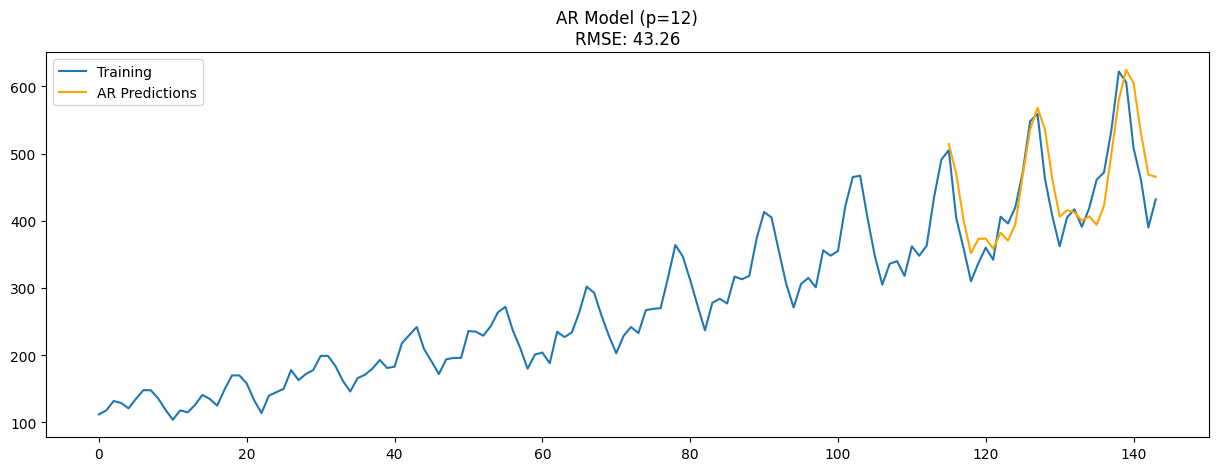

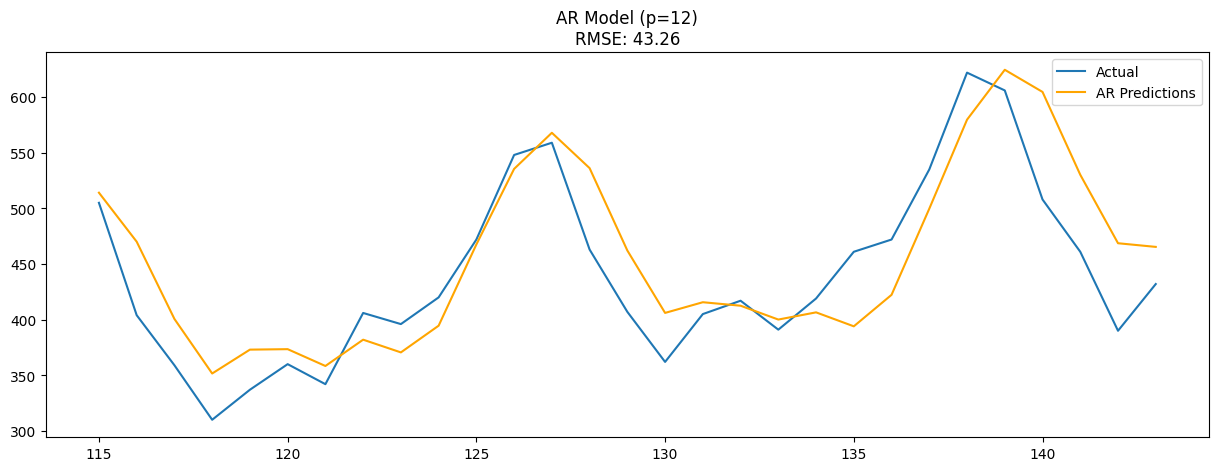

In [78]:
run_AR_analysis(train_data=train_data, test_data=test_data, p=12)

### MA Model

In [79]:
def run_MA_analysis(train_data, test_data, q):
    # Train MA model
    ma_model = ARIMA(train_data, order=(0, 0, q))
    ma_model_fit = ma_model.fit()

    # Make predictions on the testing data
    ma_predictions = ma_model_fit.predict(
        start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False
    )

    # Calculate RMSE
    ma_rmse = np.sqrt(mean_squared_error(test_data, ma_predictions))

    # Visualize MA model performance
    plt.figure(figsize=(15, 5))
    plt.plot(np.concatenate([train_data, test_data]), label="Training")
    plt.plot(ma_predictions, color="orange", label="MA Predictions")
    plt.legend()
    plt.title(f"MA Model (q={q})\nRMSE: {ma_rmse:.2f}")
    plt.show()

    # Visualize MA model performance
    plt.figure(figsize=(15, 5))
    plt.plot(test_data, label="Actual")
    plt.plot(ma_predictions, color="orange", label="MA Predictions")
    plt.legend()
    plt.title(f"MA Model (q={q})\nRMSE: {ma_rmse:.2f}")
    plt.show()

/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


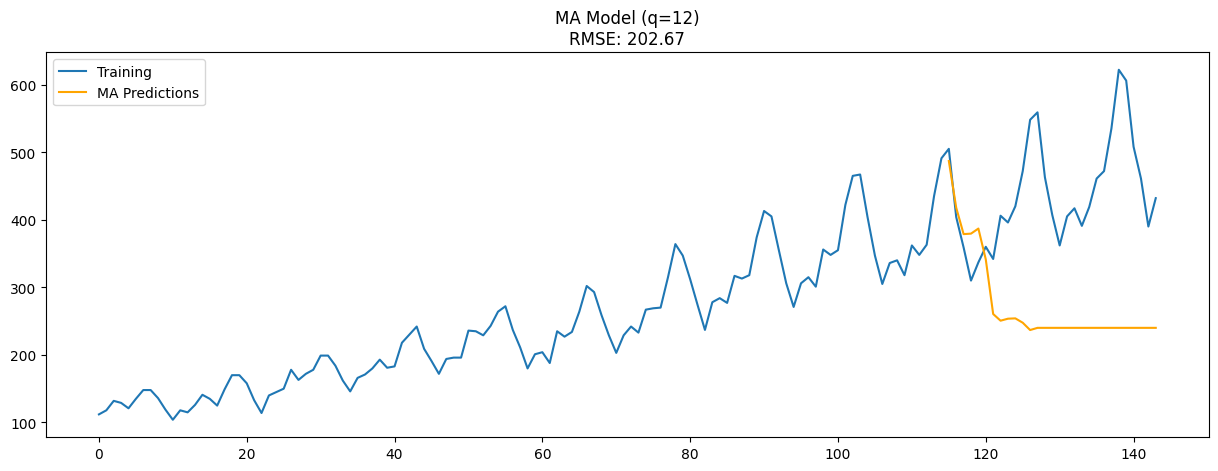

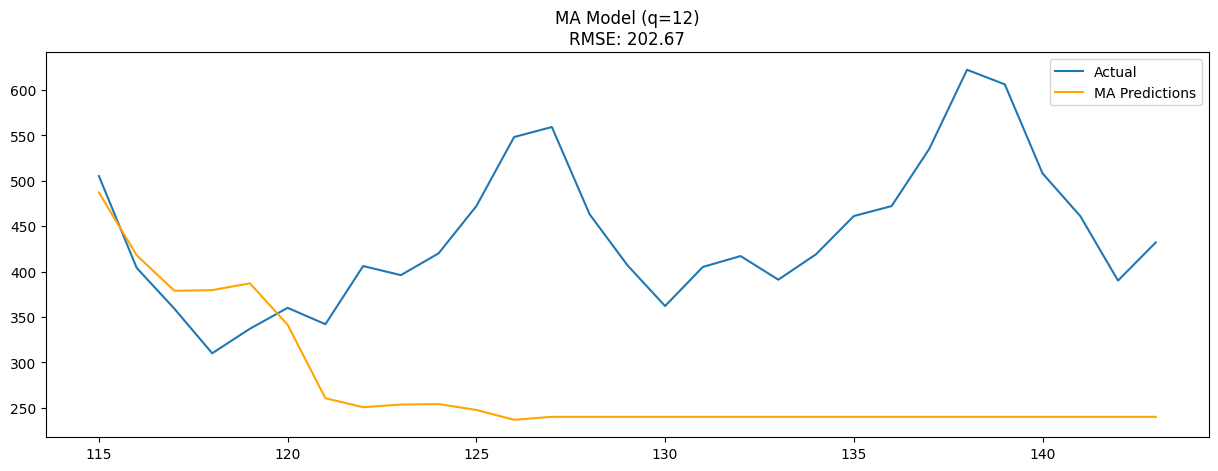

In [80]:
run_MA_analysis(train_data=train_data, test_data=test_data, q=12)

### ARIMA Model

In [82]:
def run_manual_ARIMA_analysis(train_data, test_data, p, d, q):
    # Train ARIMA model
    arima_model = ARIMA(train_data, order=(p, d, q))
    arima_model_fit = arima_model.fit()

    # Make predictions on the testing data
    arima_predictions = arima_model_fit.predict(
        start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False
    )

    # Calculate RMSE
    arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))

    # Visualize ARIMA model performance
    plt.figure(figsize=(15, 5))
    plt.plot(np.concatenate([train_data, test_data]), label="Training")
    plt.plot(arima_predictions, color="orange", label="MA Predictions")
    plt.legend()
    plt.title(f"ARIMA Model (p={p}, d={d}, q={q})\nRMSE: {arima_rmse:.2f}")
    plt.show()

    # Visualize ARIMA model performance
    plt.figure(figsize=(15, 5))
    plt.plot(test_data, label="Actual")
    plt.plot(arima_predictions, color="orange", label="MA Predictions")
    plt.legend()
    plt.title(f"ARIMA Model (p={p}, d={d}, q={q})\nRMSE: {arima_rmse:.2f}")
    plt.show()

/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


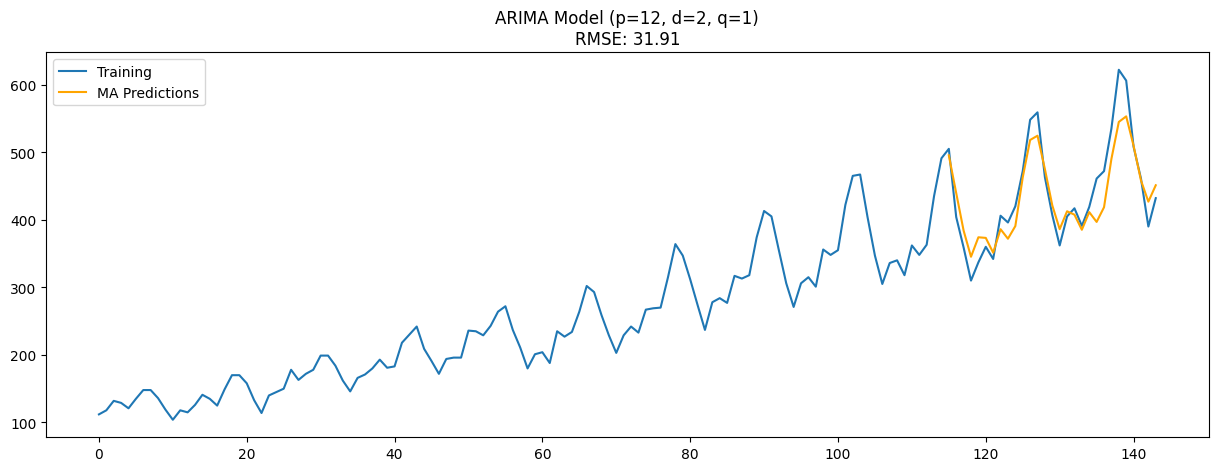

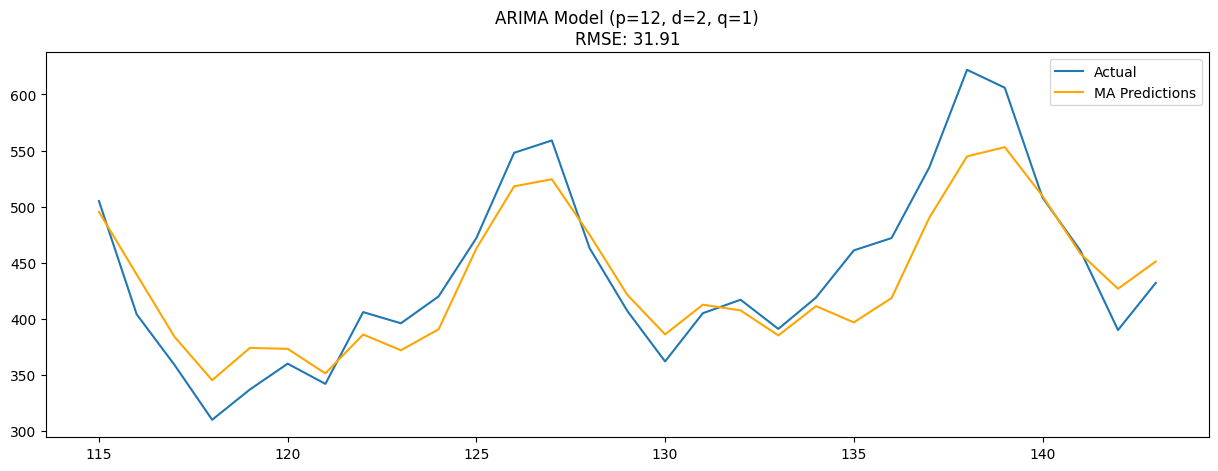

In [83]:
run_manual_ARIMA_analysis(train_data=train_data, test_data=test_data, p=12, d=2, q=1)

In [95]:
def run_auto_ARIMA_analysis(train_data, test_data, p_range, d_range, q_range):
    # Define parameter ranges
    param_combinations = product(p_range, d_range, q_range)

    best_aic = float("inf")
    best_params = None

    for params in tqdm(param_combinations):
        warnings.filterwarnings("ignore")

        p, d, q = params
        arima_model = ARIMA(train_data, order=(p, d, q))

        arima_model_fit = arima_model.fit()
        aic = arima_model_fit.aic

        warnings.resetwarnings()

        if aic < best_aic:
            best_aic = aic
            best_params = params

    # Train ARIMA model with best parameters
    p, d, q = best_params
    best_arima_model = ARIMA(train_data, order=(p, d, q))
    best_arima_model_fit = best_arima_model.fit()

    # Make predictions
    best_arima_predictions = best_arima_model_fit.predict(
        start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False
    )

    # Calculate RMSE
    best_arima_rmse = np.sqrt(mean_squared_error(test_data, best_arima_predictions))

    # Visualize ARIMA model performance
    plt.figure(figsize=(15, 5))
    plt.plot(np.concatenate([train_data, test_data]), label="Training")
    plt.plot(best_arima_predictions, color="orange", label="MA Predictions")
    plt.legend()
    plt.title(f"ARIMA Model (p={p}, d={d}, q={q})\nRMSE: {best_arima_rmse:.2f}")
    plt.show()

    # Visualize ARIMA model performance
    plt.figure(figsize=(15, 5))
    plt.plot(test_data, label="Actual")
    plt.plot(best_arima_predictions, color="orange", label="MA Predictions")
    plt.legend()
    plt.title(f"ARIMA Model (p={p}, d={d}, q={q})\nRMSE: {best_arima_rmse:.2f}")
    plt.show()

108it [01:03,  1.71it/s]
/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


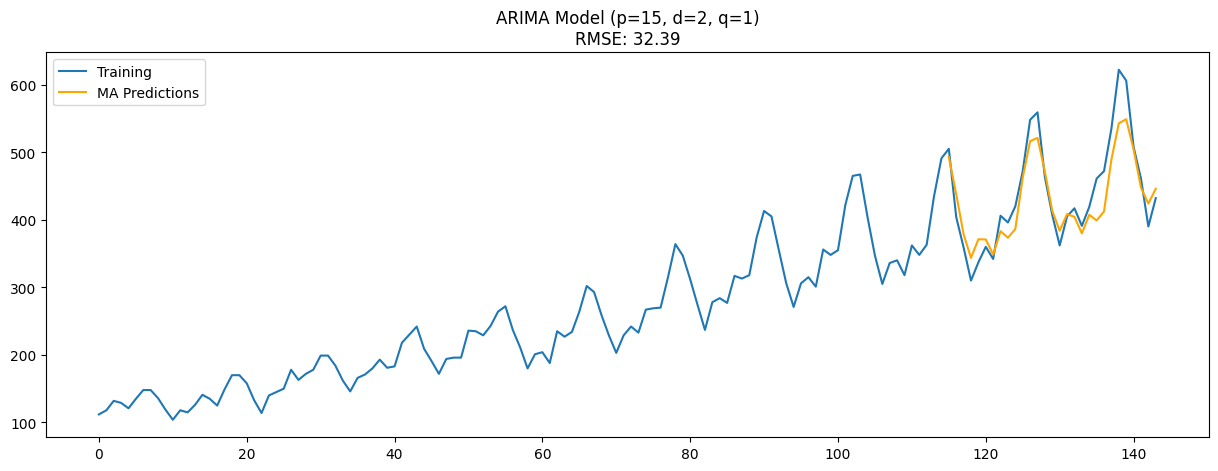

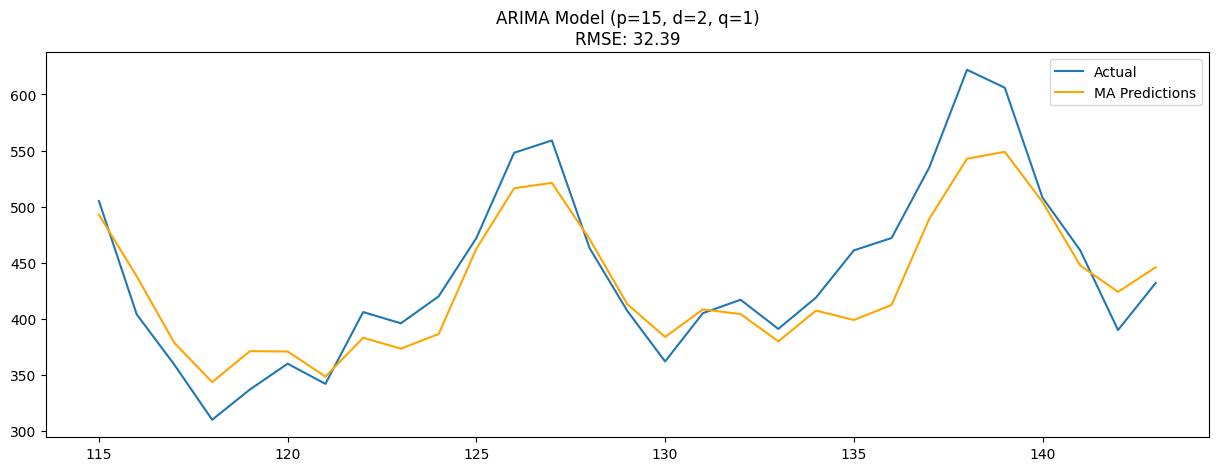

In [96]:
run_auto_ARIMA_analysis(
    train_data=train_data,
    test_data=test_data,
    p_range=range(6, 24),
    d_range=range(0, 3),
    q_range=range(0, 2),
)

# 5. Feature Development

To use Time Series as part of Machine Learning models, different features can be extracted from it. This section demonstrate how to use:
- Date features
- Lag features
- Rolling Window features
- Expanding Window features

### Reload Dataset

In [101]:
# Load the AirPassengers Dataset
# AirPassengers = sm.datasets.get_rdataset("AirPassengers").data
air_passengers = pd.read_csv("AirPassengers.csv").rename(
    {"Month": "date", "#Passengers": "num_passengers"}, axis=1
)
air_passengers["date"] = pd.to_datetime(air_passengers["date"])
air_passengers.head()

,date,num_passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### Date Features

In [102]:
air_passengers["Year"] = air_passengers["date"].dt.year
air_passengers["Month"] = air_passengers["date"].dt.month
air_passengers.head()

,date,num_passengers,Year,Month
0,1949-01-01,112,1949,1
1,1949-02-01,118,1949,2
2,1949-03-01,132,1949,3
3,1949-04-01,129,1949,4
4,1949-05-01,121,1949,5


### Lag Features

In [103]:
for i in range(12):
    lag = i + 1
    air_passengers["lag_" + str(lag)] = air_passengers["num_passengers"].shift(lag)

air_passengers.head(20)

,date,num_passengers,Year,Month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,1949-01-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118,1949,2,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132,1949,3,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-01,129,1949,4,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-01,121,1949,5,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1949-06-01,135,1949,6,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1949-07-01,148,1949,7,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1949-08-01,148,1949,8,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN
8,1949-09-01,136,1949,9,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN
9,1949-10-01,119,1949,10,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN


### Rolling Window Features

In [104]:
air_passengers["rw_mean"] = air_passengers["num_passengers"].rolling(12).mean()
air_passengers["rw_stddev"] = air_passengers["num_passengers"].rolling(12).std()
air_passengers.head(20)

,date,num_passengers,Year,Month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rw_mean,rw_stddev
0,1949-01-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118,1949,2,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132,1949,3,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-01,129,1949,4,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-01,121,1949,5,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1949-06-01,135,1949,6,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1949-07-01,148,1949,7,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1949-08-01,148,1949,8,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1949-09-01,136,1949,9,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN
9,1949-10-01,119,1949,10,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN


### Expanding Window features

In [105]:
air_passengers["ew_mean"] = air_passengers["num_passengers"].expanding(12).mean()
air_passengers["ew_stddev"] = air_passengers["num_passengers"].expanding(12).std()
air_passengers.head(20)

,date,num_passengers,Year,Month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rw_mean,rw_stddev,ew_mean,ew_stddev
0,1949-01-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118,1949,2,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132,1949,3,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04-01,129,1949,4,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05-01,121,1949,5,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1949-06-01,135,1949,6,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1949-07-01,148,1949,7,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1949-08-01,148,1949,8,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1949-09-01,136,1949,9,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1949-10-01,119,1949,10,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Appendix

## Sine Waveform with ADF / PADF

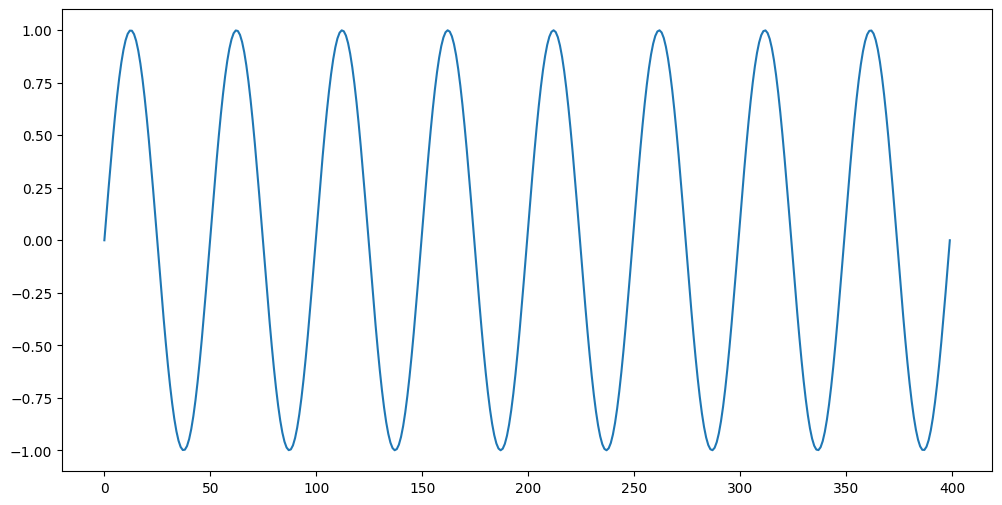

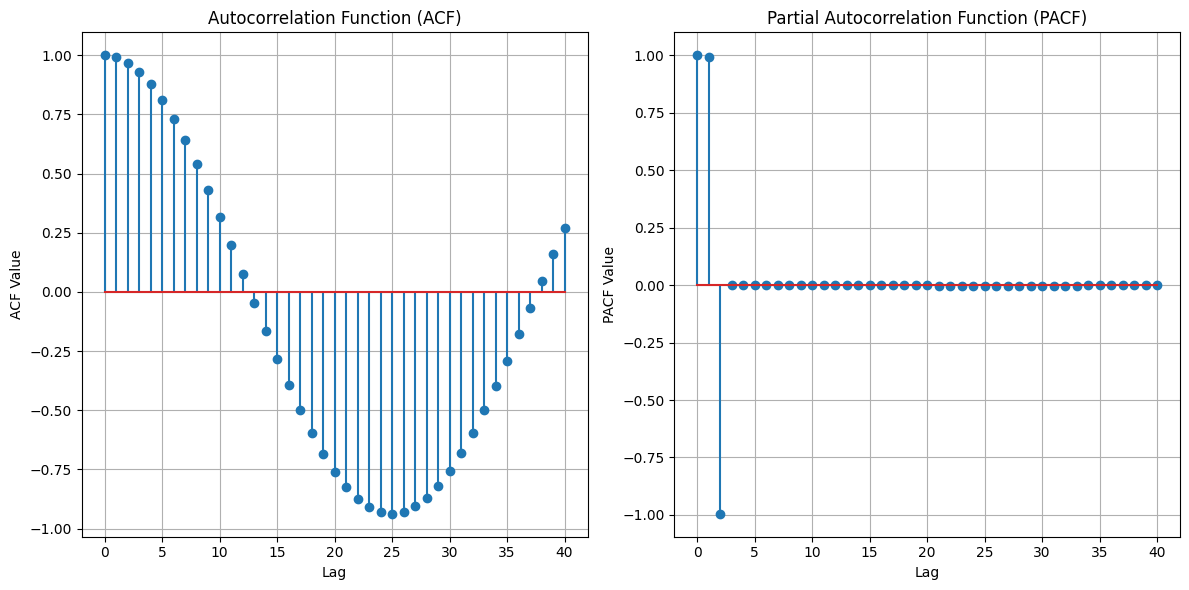

In [48]:
# Define the range of x values
x = np.linspace(0, 16 * np.pi, 400)
y = np.sin(x)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))
plt.plot(y)

# Compute the Autocorrelation Function (ACF)
acf = sm.tsa.acf(y, nlags=40, fft=True)

# Compute the Partial Autocorrelation Function (PACF)
pacf = sm.tsa.pacf(y, nlags=40, method=None)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plt.stem(acf)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF Value")
plt.grid(True)

# Plot PACF
plt.subplot(1, 2, 2)
plt.stem(pacf)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("PACF Value")
plt.grid(True)

plt.tight_layout()
plt.show()